Epoch: [0/1], Batch Num: [0/12]
Discriminator Loss: 1.2254, Generator Loss: 0.5256
D(x): 0.5373, D(G(z)): 0.4530


Epoch: [0/1], Batch Num: [1/12]
Discriminator Loss: 1.1055, Generator Loss: 0.4625
D(x): 0.5607, D(G(z)): 0.4090


Epoch: [0/1], Batch Num: [2/12]
Discriminator Loss: 0.9443, Generator Loss: 0.4078
D(x): 0.6174, D(G(z)): 0.3693


Epoch: [0/1], Batch Num: [3/12]
Discriminator Loss: 0.8777, Generator Loss: 0.3648
D(x): 0.6256, D(G(z)): 0.3344


Epoch: [0/1], Batch Num: [4/12]
Discriminator Loss: 0.7516, Generator Loss: 0.3297
D(x): 0.6801, D(G(z)): 0.3049


Epoch: [0/1], Batch Num: [5/12]
Discriminator Loss: 0.6068, Generator Loss: 0.3026
D(x): 0.7593, D(G(z)): 0.2807


Epoch: [0/1], Batch Num: [6/12]
Discriminator Loss: 0.5749, Generator Loss: 0.2786
D(x): 0.7617, D(G(z)): 0.2596


Epoch: [0/1], Batch Num: [7/12]
Discriminator Loss: 0.4901, Generator Loss: 0.2607
D(x): 0.8107, D(G(z)): 0.2428


Epoch: [0/1], Batch Num: [8/12]
Discriminator Loss: 0.5282, Generator Loss: 0.24

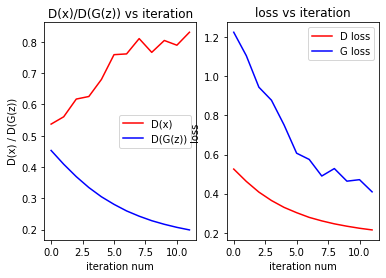

In [1]:
import torch
from torch import nn, optim
from torch.autograd import Variable
import torch.optim as optim
import scipy.io as scio
import numpy as np
from sklearn import preprocessing
import torch.utils.data as Data
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# 8/27
# 前版本train_dis()存在错误，real_data, fake_data出现错误，修改完成
'''
 存在问题：
 1. 数据标准化可能存在问题
 2. 增加训练数据量
 3. LSTM中in_dim维度应该选择多少
 4. h_0, c_0目前是空白状态
'''
################################
# process data
################################

datafile = "C:./asdf.mat"
data = scio.loadmat(datafile)

a = data['est_meals_tot_time_weight']
b = [0,0,0,0,0,0,0,0,0,0,0,0]
# 将4281行变成4320行。 4320 = 40分钟*（36/天）* 3天

for i in range(0,39):
    a = np.row_stack((a, b))

# 将a转置, 12*4320 -> 12*3*36*40
a = a.T

# min-max标准化到(-1, 1)
min_max_scaler = preprocessing.MinMaxScaler(feature_range = (-1, 1))
a = min_max_scaler.fit_transform(a)



# 构造 dataloader

seq_len = 36
batch_size = 3
in_dim = 40
hidden_dim = 128
n_layer = 1
class REAL_DATA(torch.utils.data.Dataset):
    def __init__(self):
        self.datafile2 = "./real_meal.mat"
        self.real_data = scio.loadmat(self.datafile2)
        self.real_data = self.real_data['est_meals_tot_no_aggregate']
        self.real_data = self.real_data.T    
           
        #self.transform = torchvision.transforms.Compose([
        #                                                  torchvision.transforms.ToTensor(),
        #                                                  torchvision.transforms.Normalize(mean=.5, std=.5)
        #                                                ])  #正则化到 (-1, 1)
        self.transform = torchvision.transforms.Compose([
                                                          torchvision.transforms.ToTensor()
                                                        ])
        self.real_data = self.transform(self.real_data)
        self.real_data = self.real_data.reshape(12, 4320)    
        self.min_max_scaler = preprocessing.MinMaxScaler(feature_range = (-1, 1))
        self.real_data = self.min_max_scaler.fit_transform(self.real_data)
    def __getitem__(self, index):
        return self.real_data[index]
    def __len__(self):
        return len(self.real_data)
    def data(self):
        return self.real_data 

temp_data = REAL_DATA()
Real_Data = torch.from_numpy(temp_data.data())
data_loader_fake = Data.DataLoader(a, 1, shuffle=False)


################################
# define model
################################

class Generator(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_layer):
        super(Generator, self).__init__()
        self.n_layer = n_layer
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(in_dim, hidden_dim, n_layer, batch_first=True)
        self.hidden_out = nn.Sequential(
            nn.Linear(hidden_dim, 40),
            nn.Sigmoid()
        )
        self.h_s = None
        self.h_c = None
    def forward(self, x):
        r_out, (h_s, h_c) = self.lstm(x)
        output = self.hidden_out(r_out)
        return output

class Discriminator(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_layer):
        super(Discriminator, self).__init__()
        self.n_layer = n_layer
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(in_dim, hidden_dim, n_layer, batch_first=True)
        self.hidden_out = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
        #self.hidden_out = nn.Linear(hidden_dim, 1)
        self.h_s = None
        self.h_c = None
    def forward(self, x):
        r_out, (h_s, h_c) = self.lstm(x)
        output = self.hidden_out(r_out)
        return output

################################
# training, save model
################################

generator = Generator(in_dim, hidden_dim, n_layer)
discriminator = Discriminator(1440, 128, 1)

loss = nn.BCELoss() # 损失函数
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002) # 优化器
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

def generate_label(label, batch_sizes):
    if (label == 0):
        a = np.zeros([1, batch_size, 1])
    else:
        a = np.ones([1, batch_size, 1])

    a = torch.from_numpy(a)
    a = Variable(a, requires_grad = True)
    return a.float().detach()


def train_dis(optimizer, real_data, fake_data):
    optimizer.zero_grad()
    # train on real data
    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real, generate_label(1, 3))
    error_real.backward()

    # train on fake data
    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake, generate_label(0, 3))
    error_fake.backward()

    # Update weights with gradients
    optimizer.step()

    return error_real + error_fake, prediction_real, prediction_fake


def train_gen(optimizer, generated_data):
    # zero the parameter gradients
    optimizer.zero_grad()
    prediction = discriminator(generated_data)
    error = loss( prediction, generate_label(0, 3) )
    error.backward()
    optimizer.step()
    return error

def concat_data(gen_output):
    a = []
    for i in range(36):
        for j in range(40):
            a.append(gen_output[i][0][j])
    a = np.array(a)
    a.resize(1,1,1440)

    b = []
    for i in range(36):
        for j in range(40):
            b.append(gen_output[i][1][j])
    b = np.array(b)
    b.resize(1,1,1440)

    c = []
    for i in range(36):
        for j in range(40):
            c.append(gen_output[i][2][j])
    c = np.array(c)
    c.resize(1,1,1440)

    d = np.zeros([1, 3, 1440])
    d[:, 0, :] = a
    d[:, 1, :] = b
    d[:, 2, :] = c
    d  = torch.from_numpy(d).float()
    return d

class Logger:
    def display_status(self, epoch, num_epochs, n_batch, num_batches, d_error, g_error, d_pred_real, d_pred_fake):
        f = open("C:\\Users\\Ke Ma\\Desktop\\drop\\results.txt", 'a')
        f.write("Epoch: [{}/{}], Batch Num: [{}/{}]".format(epoch, num_epochs, n_batch, num_batches))
        f.write("\n")
        print("Epoch: [{}/{}], Batch Num: [{}/{}]".format(epoch, num_epochs, n_batch, num_batches))
        f.write('Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(d_error, g_error))
        f.write("\n")
        print('Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(d_error, g_error))
        f.write('D(x): {:.4f}, D(G(z)): {:.4f}'.format(d_pred_real.mean(), d_pred_fake.mean()))
        f.write("\n")
        print('D(x): {:.4f}, D(G(z)): {:.4f}'.format(d_pred_real.mean(), d_pred_fake.mean()))
        print("\n")
        f.close()

logger = Logger()
num_epochs = 1
num_batches = len(data_loader_fake)
D_ = []
G_ = []
it = []
de = []
ge = []

def draw_pic(D, G, it, de, ge):
    plt.figure(1)
    plt.subplot(1, 2, 1)
    plt.plot(it, D, color='r', label='D(x)')
    plt.plot(it, G, color='b', linestyle='-', label='D(G(z))')
    plt.xlabel("iteration num")
    plt.ylabel("D(x) / D(G(z))")
    plt.legend()
    plt.title("D(x)/D(G(z)) vs iteration")
   
    plt.subplot(1, 2, 2)
    plt.plot(it, ge, color='r', label='D loss')
    plt.plot(it, de, color='b', linestyle='-', label='G loss')
    plt.xlabel("iteration num")
    plt.ylabel("loss")
    plt.legend()
    plt.title("loss vs iteration") 
   
    plt.show()


for epoch in range(num_epochs):
    for n_batch, data in enumerate(data_loader_fake):
        x = data.reshape(seq_len, batch_size, in_dim).float()
        

        # Train discriminator
            # 生成fake data
        out = generator(x)
        fake_data = concat_data(out).detach()    # [1, 1, 1440] -> [1, 3, 1440]
            # 生成real data
        
        real_data = Real_Data[n_batch]
        real_data = real_data.reshape(1, 3, 1440).float()
        #train_gen(g_optimizer, gen_out)
        d_error, d_pred_real, d_pred_fake = train_dis(d_optimizer, real_data, fake_data)

        # Train generator
        g_error = train_gen(g_optimizer, fake_data)

        #画图
        D_.append(d_pred_real.mean().item()) #存入list，画图
        G_.append(d_pred_fake.mean().item())
        it.append(epoch*12 + n_batch)
        de.append(d_error.item())
        ge.append(g_error.item())

        logger.display_status(
            epoch, num_epochs, n_batch, num_batches,
            d_error, g_error, d_pred_real, d_pred_fake
        )

draw_pic(D_, G_, it, de, ge)  #画图

################################
# test
################################

